## Overview

1. Read API data that represents on-call coverage by team


2. Manipulate the json into a pandas dataframe by group, primary/ secondary on-call for each day of the week
    - the report displays data from Monday to Monday currently (hard-coded for 9/24/18 through 10/1/18)
    - shifts with replacements will need to show that information for any day(s) that they will be providing coverage for along with the start time
    - the rotation time should similarly show the time that the primary/ secondary, etc...will be taking over from a coverage standpoint
    - the incident management group is construted from a nested group (Infrastructure On-Call Manager | Director | Leadership)
    
    
3. Pass it to a jinja template for output
    



In [86]:
# imports for data manipulation
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from IPython.display import display, HTML
from IPython.display import Image

# date and time imports
from datetime import timedelta, datetime
from pytz import timezone
import calendar

# email and template imports
from smtplib import SMTP  # sending email
from email.mime.text import MIMEText  # constructing messages
from jinja2 import Environment  # Jinja2 templating

# general purpose imports
import json
import re
import pprint



pp = pprint.PrettyPrinter(indent=4)

In [87]:
src_file_path = ('../data/source/')
prc_file_path = ('../data/processed/')
out_file_path = ('../data/output/')

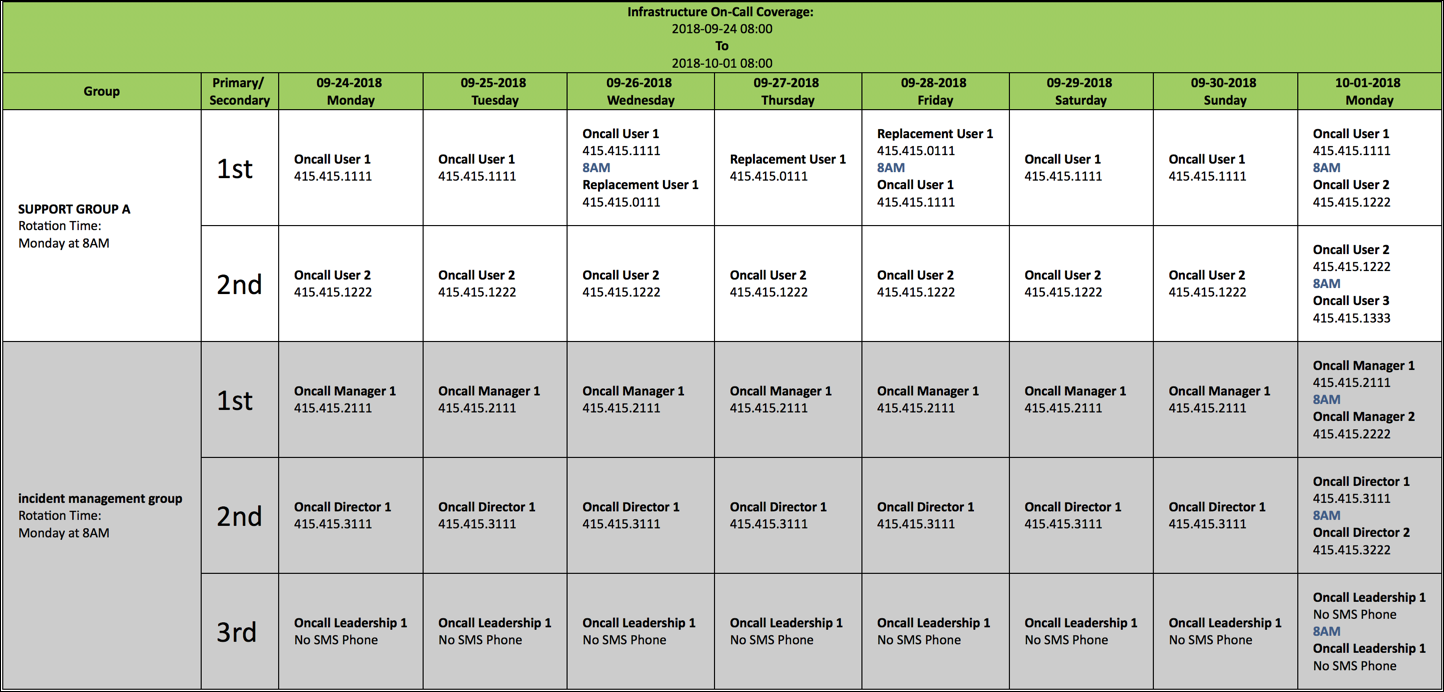

In [88]:
Image(filename=out_file_path + 'example_image.png') 

## Read the API data from a flat file

In [89]:
with open(src_file_path + 'infra_email_content_dictionary.txt') as file:
    raw_data = file.read()

dict_data = json.loads(raw_data)

groups = dict_data['data']

In [90]:
def convert_utc_to_local_time(datetime_string):
    date_str = datetime_string
    datetime_obj = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ")
    datetime_obj_utc = datetime_obj.replace(tzinfo=timezone('UTC'))
    datetime_obj_pacific = datetime_obj_utc.astimezone(timezone('US/Pacific'))

    return (datetime_obj_pacific.strftime('%Y-%m-%d %H:%M'))



In [91]:
def convert_local_time_rpt_fmt(datetime_string):
    date_str = datetime_string
    datetime_obj = datetime.strptime(date_str, "%Y-%m-%d %H:%M")

    return datetime_obj.strftime("%B %d, %Y %H:%M")



#### Function call commented as the group data will be read from a file

In [92]:
def get_grp_data(report_type, groups, base_url, grp_url_parts, report_from_utc, report_to_utc, wsun, wspw):
    grp_string = ','.join(groups)
    url = base_url + grp_url_parts[0] + grp_string + grp_url_parts[1]
    url += '&from=' + report_from_utc
    url += '&to=' + report_to_utc

    response = requests.get(url, auth=HTTPBasicAuth(wsun, wspw))
    if (response.status_code == 200):
        response_data = response.json()
    else:
        response_data = response.json()

    # TODO:  this should also have a try execpt block in case there's a locking issue
    with open(report_type + '_email_content_dictionary' + '.txt', 'w') as file:
        file.write(json.dumps(response_data))

    return response_data



#### Function call commented as the device data will be read from a file

In [93]:
def get_dvc_data(unique_members, base_url, device_url_parts, wsun, wspw):
    """ Get SMS Phone for all members in the report"""
    device_dict = {}
    for un in unique_members:
        device_url = base_url + device_url_parts[0] + un + device_url_parts[1]
        response = requests.get(device_url, auth=HTTPBasicAuth(wsun, wspw))
        response_data = response.json()
        if (response.status_code == 200):
            device_address = format_phone(response_data['phoneNumber'])

        else:
            device_address = 'No SMS Phone'

        device_dict.update({un: device_address})

    return device_dict



#### The intent of this function is to merge the data from three different groups into one as each has it's own rotation.  This will allow it to appear as a single group on the report but display dynamic data from three nested groups.

In [94]:
def combine_incident_management_rotation(df2):
    inc_mgt_shift_1 = []
    inc_mgt_shift_2 = []

    inc_mgr_shift1 = df2.loc['Infrastructure On-Call Manager']['members.data'][0][0]
    inc_mgr_shift2 = df2.loc['Infrastructure On-Call Manager']['members.data'][1][0]

    inc_dir_shift1 = df2.loc['Infrastructure On-Call Director']['members.data'][0][0]
    inc_dir_shift1['position'] = 2
    inc_dir_shift2 = df2.loc['Infrastructure On-Call Director']['members.data'][1][0]
    inc_dir_shift2['position'] = 2

    inc_ldr_shift1 = df2.loc['Infrastructure On-Call Leadership']['members.data'][0][0]
    inc_ldr_shift1['position'] = 3
    # the Leadership group has no rotation and will append the first shift's details
    # inc_ldr_shift2 = df2.loc['Infrastructure On-Call Leadership']['members.data'][1][0]
    # inc_ldr_shift2['position'] = 3

    inc_mgt_shift_1.extend((inc_mgr_shift1, inc_dir_shift1, inc_ldr_shift1))
    inc_mgt_shift_2.extend((inc_mgr_shift2, inc_dir_shift2, inc_ldr_shift1))

    # udpate the incident management group details for the first shift
    df2.loc[('incident management group')]['members.data'][0][0] = inc_mgt_shift_1[0]
    df2.loc[('incident management group')]['members.data'][0][1] = inc_mgt_shift_1[1]
    df2.loc[('incident management group')]['members.data'][0][2] = inc_mgt_shift_1[2]

    # udpate the incident management group details for the second shift
    df2.loc[('incident management group')]['members.data'][1][0] = inc_mgt_shift_2[0]
    df2.loc[('incident management group')]['members.data'][1][1] = inc_mgt_shift_2[1]
    df2.loc[('incident management group')]['members.data'][1][2] = inc_mgt_shift_2[2]

    # drop the individual groups from the dataframe now that the combined group has been created
    df2.drop(['Infrastructure On-Call Manager'], level=0, inplace=True)
    df2.drop(['Infrastructure On-Call Director'], level=0, inplace=True)
    df2.drop(['Infrastructure On-Call Leadership'], level=0, inplace=True)
    
    

#### Most groups should only display the primary and secondary members but some groups will display up to three positions

In [95]:
def set_position_limit(group, member_count):
    if group == 'incident management group':
        return 3
    else:
        if member_count >= 2:
            return 2
        else:
            return member_count
        
        

#### Create and return a dictionary of MM-DD-YYYY keys and day of week values.  It will also return the report from and to dates in local time.

In [96]:
def get_report_days(report_from_utc, report_to_utc):
    filter_dt_from_local = convert_utc_to_local_time(report_from_utc)
    filter_dt_to_local = convert_utc_to_local_time(report_to_utc)

    d1 = datetime.strptime(filter_dt_from_local, '%Y-%m-%d %H:%M')
    d2 = datetime.strptime(filter_dt_to_local, '%Y-%m-%d %H:%M')
    delta = d2 - d1
    delta_in_days = delta.days
    counter = 0
    day_dict = {}

    while counter <= delta_in_days:
        loop_timestamp = d1
        loop_day_of_week = loop_timestamp + timedelta(days=counter)
        day_of_week = calendar.day_name[loop_day_of_week.weekday()]
        day_dict[loop_day_of_week.strftime('%m-%d-%Y')] = day_of_week
        counter += 1

    return (day_dict, filter_dt_from_local, filter_dt_to_local)



#### This function will collect all unique report members for each shift up to the position limit for the given group to be used to query the user's device info.

In [97]:
def get_unique_members(data_frame):
    all_members = []
    for i in data_frame['report_members_count']:
        position_limit = i

        for k, v in data_frame['members.data'].items():
            md = json_normalize(v)
            for i, m in md.iterrows():
                if 'replacements.data' in m.keys():
                    try:
                        rd = json_normalize(m['replacements.data'])
                        for i, r in rd.iterrows():
                            if r['replacement.recipientType'] == 'PERSON' and m['position'] <= position_limit:
                                all_members.append(r['replacement.targetName'])
                    except Exception as e:
                        # this is needed to avoid NaN values within the flattened data structure
                        pass
                else:
                    if m['member.recipientType'] == 'PERSON' and m['position'] <= position_limit:
                        all_members.append(m['member.targetName'])

    unique_members = set(all_members)

    print(unique_members)

    return unique_members



###  <font color='red'>Main processing block of the report.  Used to create a list of lists representing each group's shift information by day.</font>  

In [98]:
def create_oncall_list(day, replacements, member_data, report_members_count, device_dict, date):
    md = json_normalize(member_data)

    if day == True:
        if replacements == False:
            oncall_list = []
            for i, m in md.iterrows():
                if m['position'] <= report_members_count:
                    if m['member.recipientType'] == 'PERSON':
                        js = {'position': m['position'],
                              'target_name': m['member.firstName'] + ' ' + m['member.lastName'],
                              'device_address': device_dict[m['member.targetName']],
                              'rotation_time': ''}
                        oncall_list.append(js)

                    else:
                        js = {'position': m['position'], 'target_name': 'See ' + ' ' + m['member.targetName'],
                              'rotation_time': ''}
                        oncall_list.append(js)

            return json.dumps(oncall_list)

        else:
            oncall_list = []
            for i, m in md.iterrows():
                if 'replacements.data' in m.keys():
                    try:
                        rd = json_normalize(m['replacements.data'])
                        for i, r in rd.iterrows():

                            response = in_schedule_replacement(str(r['start']), str(r['end']), str(date))

                            if r['replacement.recipientType'] == 'PERSON' and response[0] == True:
                                # only set the rotation if the oncall list for the given day has more than one member
                                if i > 0:
                                    rotation_time = response[1]
                                else:
                                    rotation_time = ''

                                js = {'position': m['position'],
                                      'target_name': r['replacement.firstName'] + ' ' + r['replacement.lastName'],
                                      'device_address': device_dict[r['replacement.targetName']],
                                      'rotation_time': rotation_time}
                                oncall_list.append(js)
                    except Exception as e:
                        # this is needed to avoid NaN values within the flattened data structure
                        if m['position'] <= report_members_count:
                            if m['member.recipientType'] == 'PERSON':
                                js = {'position': m['position'],
                                      'target_name': m['member.firstName'] + ' ' + m['member.lastName'],
                                      'device_address': device_dict[m['member.targetName']],
                                      'rotation_time': ''}
                                oncall_list.append(js)

                            else:
                                js = {'position': m['position'], 'target_name': 'See ' + ' ' + m['member.targetName'],
                                      'device_address': '',
                                      'rotation_time': ''}
                                oncall_list.append(js)

                else:
                    if m['position'] <= report_members_count:
                        if m['member.recipientType'] == 'PERSON':
                            js = {'position': m['position'],
                                  'target_name': m['member.firstName'] + ' ' + m['member.lastName'],
                                  'device_address': device_dict[m['member.targetName']],
                                  'rotation_time': ''}
                            oncall_list.append(js)

                        else:
                            js = {'position': m['position'], 'target_name': 'See ' + ' ' + m['member.targetName'],
                                  'device_address': '',
                                  'rotation_time': ''}
                            oncall_list.append(js)

        return json.dumps(oncall_list)

    return np.nan



#### This function will return True or False based on whether or not the shift falls within the day of the week

In [99]:
def in_schedule(start_local, end_local, rotation_start_hour, day_key):
    # create a timestamp from the current day of the week within the day dictionary and add the shift start time
    revised_timestamp = pd.Timestamp(day_key).tz_localize('US/Pacific') + pd.Timedelta(hours=rotation_start_hour)
    if ((start_local <= revised_timestamp) & (revised_timestamp <= end_local)):
        return True
    else:
        return False

#### This function will return True or False based on whether or not replacement shift details fall within the day of the week.  The replacement start time will also be returned if it falls on the given day.

In [100]:
def in_schedule_replacement(start, end, day_key):
    # create a timestamp from the current day of the week within the day dictionary
    start_local = pd.Timestamp(start).tz_convert('US/Pacific')
    end_local = pd.Timestamp(end).tz_convert('US/Pacific') - pd.to_timedelta('1', unit='s')
    timestamp = pd.Timestamp(day_key).tz_localize('US/Pacific')

    if ((start_local.day == timestamp.day) | (timestamp.day == end_local.day)
            | (start_local <= timestamp <= end_local)):

        if start_local.day == timestamp.day:
            rotation_time = covert_hours_to_am_pm(start_local.hour, start_local.minute)
        else:
            rotation_time = ''

        return (True, rotation_time)
    else:
        return (False, '')

In [101]:
in_schedule_replacement('2018-09-26T15:39:00Z', '2018-10-01T015:00:00Z', '09-28-2018')

(True, '')

#### This function will check whether or not the shift has any replacements.  (the idea being that unessary conditionals will not have to be checked within subsequent functions such as "create_oncall_list")

In [102]:
def has_replacements(member_data):
    answer = False
    for m in member_data:
        if 'replacements' in m.keys():
            answer = True

    return answer

#### This function will return the start hour (and minute if not :00) with an AM/ PM format

In [103]:
def covert_hours_to_am_pm(start_hour, start_minute):
    # split the time string into hour and minute parts
    hr = start_hour
    mm = start_minute
    if mm < 10:
        mm_str = '0' + str(mm)
    else:
        mm_str = str(mm)
    setting = "AM"
    if hr >= 12:
        setting = "PM"
        hr -= 12
    elif hr == 0:
        hr = 12
    if mm > 0:
        return (("%0d" + ":%s" + setting) % (hr, mm_str))
    else:
        return (("%0d" + setting) % (hr))

#### This function will return phone numbers in a xxx.xxx.xxx format

In [104]:
def format_phone(phone):
    # strip non-numeric characters
    phone = re.sub(r'\D', '', phone)
    # remove leading 1 (area codes never start with 1)
    phone = phone.lstrip('1')
    return '{}.{}.{}'.format(phone[0:3], phone[3:6], phone[6:])

#### This function will return the name of the day of the week based on the code returned from the group's shift information

In [105]:
def get_day_name(day):
    c = calendar.TextCalendar()
    my_dict = {'MO': 0, 'TU': 1, 'WE': 2, 'TH': 3, 'FR': 4, 'SA': 5, 'SU': 6}
    return c.formatweekday(my_dict[day], 10)

#### Date variables based on current time, these have been overwritten so that the notebook data is still functional for past dates.

In [106]:
# define filters for the report start and end dates
api_date_fmt = "%Y-%m-%dT%H:%M:%SZ"
# Current time in UTC
now_utc = datetime.now(timezone('UTC'))
# Convert to US/Pacific time zone
now_pacific = now_utc.astimezone(timezone('US/Pacific'))
# US/Pacific at 8m
filter_date_from_local = now_pacific.replace(hour=0, minute=0, second=0) + timedelta(hours=8)
# UTC at 8am
filter_date_from_utc = filter_date_from_local.astimezone(timezone('UTC'))
# Find the number of days between the filter date from UTC and next Monday
next_monday_delta = timedelta((0 - filter_date_from_utc.weekday()) % 7)
#  Report from date:  Next Monday at 8am in UTC
report_from_utc_dt = (filter_date_from_utc + next_monday_delta)
#  Report to date:  Next "Next Monday" at 8am (+ 1 second) in UTC
report_to_utc_dt = (report_from_utc_dt + timedelta(days=7) + timedelta(seconds=1))
# Report from date string
report_from_utc = report_from_utc_dt.strftime(api_date_fmt)
# Report to date string
report_to_utc = report_to_utc_dt.strftime(api_date_fmt)


"""
Hard-coded dates for the purposes of this notebook
"""
report_from_utc = '2018-09-24T15:00:01Z'
report_to_utc = '2018-10-01T15:00:01Z'

#### Raw data the API turned into a data frame

In [107]:
df1 = pd.DataFrame(groups)
df1.head()

,end,group,members,shift,start
0,2018-10-01T15:00:00Z,"{'id': '3c58efc8-ef83-46ec-abb5-653d7a81abbe',...","{'count': 3, 'total': 3, 'data': [{'position':...","{'id': 'bfd6e10c-136f-45ce-ae5a-fa411108f9ac',...",2018-09-24T15:00:00Z
1,2018-10-08T15:00:00Z,"{'id': '3c58efc8-ef83-46ec-abb5-653d7a81abbe',...","{'count': 3, 'total': 3, 'data': [{'position':...","{'id': 'bfd6e10c-136f-45ce-ae5a-fa411108f9ac',...",2018-10-01T15:00:00Z
2,2018-10-01T15:00:00Z,"{'id': '41f984a0-e618-4a7d-b536-db01247953cd',...","{'count': 3, 'total': 3, 'data': [{'position':...","{'id': 'd2c93d3c-fa9c-48b9-8de0-d7993adf6b23',...",2018-09-24T15:00:00Z
3,2018-10-08T15:00:00Z,"{'id': '41f984a0-e618-4a7d-b536-db01247953cd',...","{'count': 3, 'total': 3, 'data': [{'position':...","{'id': 'd2c93d3c-fa9c-48b9-8de0-d7993adf6b23',...",2018-10-01T15:00:00Z
4,2018-10-01T15:00:00Z,"{'id': '976800f7-2ee4-48a5-b71b-747a98480d85',...","{'count': 1, 'total': 1, 'data': [{'position':...","{'id': 'e0fad516-e23c-4f33-9418-1f93a4b7e7db',...",2018-09-24T15:00:00Z


###  <font color='red'>Normalized data from initial data frame</font>  

In [108]:
# TODO:  should this be seperateed into another function call?
df2 = json_normalize(groups)
# remove entries without any shifts
df2.dropna(subset=['start', 'end'], inplace=True)
# convert the start and end time columns to US/ Pacific dates
df2['start_local'] = pd.to_datetime(df2['start']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df2['end_local'] = pd.to_datetime(df2['end']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
# grab the hour of the shift start in local time (to be used for seperating shift changes)
df2['rotation_start_hour'] = df2['start_local'].dt.hour
df2['rotation_start_minute'] = df2['start_local'].dt.minute
df2['replacements'] = df2.apply(lambda x: has_replacements(x['members.data']), axis=1)
df2['report_members_count'] = df2.apply(lambda x: set_position_limit(x['group.targetName'], x['members.count']),
                                        axis=1)
mgt_grp_df = df2[(df2['group.targetName'].str.contains('Infrastructure On-Call'))]
mgt_grp_set = set(mgt_grp_df['group.targetName'].tolist())
df2.set_index(['group.targetName', 'start', 'end'], inplace=True)
# TODO: FIX management groups
if len(mgt_grp_set) == 3:
    combine_incident_management_rotation(df2)
    
df2.head()

group.id  \
group.targetName          start                end                                                          
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  3c58efc8-ef83-46ec-abb5-653d7a81abbe   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  3c58efc8-ef83-46ec-abb5-653d7a81abbe   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  570b1795-2712-42e7-aba6-35cb9ccfe97c   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  570b1795-2712-42e7-aba6-35cb9ccfe97c   

                                                                                                      group.links.self  \
group.targetName          start                end                                                                       
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  /api/xm/1/groups/3c58efc8-ef83-46ec-abb5-653d7...   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  /api/xm/1/groups/3c58efc8-ef83-46ec-abb5-653d7...   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  /api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  /api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...   

                                                                    group.recipientType  \
group.targetName          start                end                                        
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z               GROUP   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z               GROUP   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z               GROUP   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z               GROUP   

                                                                     members.count  \
group.targetName          start                end                                   
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z              3   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z              3   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z              3   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z              3   

                                                                                                          members.data  \
group.targetName          start                end                                                                       
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...   

                                                                                                    members.links.next  \
group.targetName          start                end                                                                       
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                                                NaN   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                                                NaN   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  /api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  /api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...   

                                                                                                    members.links.self  \
group.targetName          start                end       

In [109]:
df_columns = ['shift.recurrence.frequency', 'shift.recurrence.onDays', 'rotation_start_hour', 'rotation_start_minute', 'replacements', 'members.data']
df2[df_columns].head()

shift.recurrence.frequency  \
group.targetName          start                end                                               
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                     WEEKLY   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                     WEEKLY   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                     WEEKLY   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                     WEEKLY   

                                                                    shift.recurrence.onDays  \
group.targetName          start                end                                            
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                    [MO]   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                    [MO]   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                    [MO]   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                    [MO]   

                                                                     rotation_start_hour  \
group.targetName          start                end                                         
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                    8   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                    8   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                    8   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                    8   

                                                                     rotation_start_minute  \
group.targetName          start                end                                           
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                      0   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                      0   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                      0   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                      0   

                                                                     replacements  \
group.targetName          start                end                                  
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z         False   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z         False   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z          True   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z         False   

                                                                                                          members.data  
group.targetName          start                end                                                                      
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...  
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...  
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...  
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...

In [110]:
unique_members = get_unique_members(df2)

{'oncall_user_3', 'oncall_director_2', 'oncall_manager_1', 'oncall_director_1', 'replacement_user_1', 'oncall_user_2', 'oncall_leadership_1', 'oncall_manager_2', 'oncall_user_1'}


#### The functional call has been disabled and the device dictionary hardcoded

In [111]:
# device_dict = get_dvc_data(unique_members, base_url, device_url_parts, wsun, wspw)

device_dict = {'oncall_user_1': '000.1111', 
               'oncall_user_2': '000.2222', 
               'oncall_user_3': '000.3333', 
               'replacement_user_1': '111.1111', 
               'replacement_user_2': '111.2222',
               'oncall_manager_1': '222.1111', 
               'oncall_manager_2': '222.2222', 
               'oncall_manager_3': '222.3333',
               'oncall_director_1': '333.1111',
               'oncall_director_2': '333.2222',
               'oncall_director_3': '333.3333',
               'oncall_leadership_1': '444.1111'}

#### Get dictionary of days

In [112]:
get_report_days_response = get_report_days(report_from_utc, report_to_utc)
day_dict = get_report_days_response[0]
filter_dt_from_local = get_report_days_response[1]
filter_dt_to_local = get_report_days_response[2]

day_dict

{'09-24-2018': 'Monday',
 '09-25-2018': 'Tuesday',
 '09-26-2018': 'Wednesday',
 '09-27-2018': 'Thursday',
 '09-28-2018': 'Friday',
 '09-29-2018': 'Saturday',
 '09-30-2018': 'Sunday',
 '10-01-2018': 'Monday'}

In [113]:
day_keys = []
for k, v in day_dict.items():
    df2[k] = df2.apply(lambda x: in_schedule(x['start_local'], x['end_local'], x['rotation_start_hour'], k), axis=1)
    day_keys.append(k)
    # print (k, v)

In [114]:
df_columns += day_keys
df2[df_columns].head()


shift.recurrence.frequency  \
group.targetName          start                end                                               
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                     WEEKLY   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                     WEEKLY   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                     WEEKLY   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                     WEEKLY   

                                                                    shift.recurrence.onDays  \
group.targetName          start                end                                            
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                    [MO]   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                    [MO]   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                    [MO]   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                    [MO]   

                                                                     rotation_start_hour  \
group.targetName          start                end                                         
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                    8   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                    8   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                    8   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                    8   

                                                                     rotation_start_minute  \
group.targetName          start                end                                           
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                      0   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                      0   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z                      0   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z                      0   

                                                                     replacements  \
group.targetName          start                end                                  
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z         False   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z         False   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z          True   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z         False   

                                                                                                          members.data  \
group.targetName          start                end                                                                       
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z  [{'position': 1, 'delay': 0, 'escalationType':...   

                                                                     09-24-2018  \
group.targetName          start                end                                
incident management group 2018-09-24T15:00:00Z 2018-10-01T15:00:00Z        True   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z       False   
SUPPORT GROUP A           2018-09-24T15:00:00Z 2018-10-01T15:00:00Z        True   
                          2018-10-01T15:00:00Z 2018-10-08T15:00:00Z       False   

                                               

In [115]:
for day in day_keys:
    df2[day] = df2.apply(
        lambda x: create_oncall_list(x[day], x['replacements'], x['members.data'], x['report_members_count'],
                                        device_dict, day),
        axis=1)
df2.reset_index(inplace=True)
df2

,group.targetName,start,end,group.id,group.links.self,group.recipientType,members.count,members.data,members.links.next,members.links.self,...,replacements,report_members_count,09-24-2018,09-25-2018,09-26-2018,09-27-2018,09-28-2018,09-29-2018,09-30-2018,10-01-2018
0,incident management group,2018-09-24T15:00:00Z,2018-10-01T15:00:00Z,3c58efc8-ef83-46ec-abb5-653d7a81abbe,/api/xm/1/groups/3c58efc8-ef83-46ec-abb5-653d7...,GROUP,3,"[{'position': 1, 'delay': 0, 'escalationType':...",NaN,/api/xm/1/groups/3c58efc8-ef83-46ec-abb5-653d7...,...,False,3,"[{""position"": 1, ""target_name"": ""Oncall Manage...","[{""position"": 1, ""target_name"": ""Oncall Manage...","[{""position"": 1, ""target_name"": ""Oncall Manage...","[{""position"": 1, ""target_name"": ""Oncall Manage...","[{""position"": 1, ""target_name"": ""Oncall Manage...","[{""position"": 1, ""target_name"": ""Oncall Manage...","[{""position"": 1, ""target_name"": ""Oncall Manage...","[{""position"": 1, ""target_name"": ""Oncall Manage..."
1,incident management group,2018-10-01T15:00:00Z,2018-10-08T15:00:00Z,3c58efc8-ef83-46ec-abb5-653d7a81abbe,/api/xm/1/groups/3c58efc8-ef83-46ec-abb5-653d7...,GROUP,3,"[{'position': 1, 'delay': 0, 'escalationType':...",NaN,/api/xm/1/groups/3c58efc8-ef83-46ec-abb5-653d7...,...,False,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""position"": 1, ""target_name"": ""Oncall Manage..."
2,SUPPORT GROUP A,2018-09-24T15:00:00Z,2018-10-01T15:00:00Z,570b1795-2712-42e7-aba6-35cb9ccfe97c,/api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...,GROUP,3,"[{'position': 1, 'delay': 0, 'escalationType':...",/api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...,/api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...,...,True,2,"[{""position"": 1, ""target_name"": ""Oncall User 1...","[{""position"": 1, ""target_name"": ""Oncall User 1...","[{""position"": 1, ""target_name"": ""Oncall User 1...","[{""position"": 1, ""target_name"": ""Replacement U...","[{""position"": 1, ""target_name"": ""Replacement U...","[{""position"": 1, ""target_name"": ""Oncall User 1...","[{""position"": 1, ""target_name"": ""Oncall User 1...","[{""position"": 1, ""target_name"": ""Oncall User 1..."
3,SUPPORT GROUP A,2018-10-01T15:00:00Z,2018-10-08T15:00:00Z,570b1795-2712-42e7-aba6-35cb9ccfe97c,/api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...,GROUP,3,"[{'position': 1, 'delay': 0, 'escalationType':...",/api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...,/api/xm/1/groups/570b1795-2712-42e7-aba6-35cb9...,...,False,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""position"": 1, ""target_name"": ""Oncall User 2..."


In [116]:
def rotation_string_to_json(x):
    rotation_list = []
    x = pd.unique(x.dropna())
    for i in x:
        rotation_list.append(json.loads(i))
    return rotation_list



In [117]:
# Process the email content dictionary string from a jinja template
def send_mail(email_content, filter_dt_from_local, filter_dt_to_local, day_dict, subject, sender, recipient,
              mail_server):
    TEMPLATE = """
        <html>
        <head>
        <title>{{subject}} {{filter_dt_from_local}} to {{filter_dt_to_local}}</title>
            <p>
            <b><SPAN STYLE='color:red'>Note: This report is intended as a broad overview of the week's on-call coverage.
            Please keep in mind that any on-call schedule changes made after this report was run will not be reflected here.
            Please check the On-Call Alerting System directly if you would like to confirm real-time on-call coverage. </SPAN></b>
            </p>
        </head>
        <body>

        <table style='border-collapse:collapse'>
            <TR bgcolor=#92D050>
              <TD style='border: 1px solid black' align=center colspan= {{ day_dict|length + 2 }}>
              <B>{{subject}}</B>
              <BR>{{filter_dt_from_local}}<BR>
              <B>To</B><BR>
              {{filter_dt_to_local}}</TD>
            </TR>
            <TR bgcolor=#92D050>
              <TD style='border: 1px solid black' align=center><B>Group</B></TD>
              <TD style='border: 1px solid black' align=center><B>Primary/
              <BR>Secondary</B></TD>

                {% for dt, wd in day_dict.items() %}
                      <TD style='border: 1px solid black' align=center><B>
                      {{ dt }}
                      <BR>
                      {{ wd }}
                      </B></TD>
                {% endfor %}
            </TR>

            {% set zeb_str_cnt = 0 %}
            {% for k, v in email_content.iterrows() %}
            {% set zeb_str_cnt = zeb_str_cnt + loop.index %}
            {% if zeb_str_cnt%2 == 0 %}
            {% set bg_color = '#cccccc' %}
            {% else %}
            {% set bg_color = '#ffffff' %}
            {% endif %}

            <TR BGCOLOR={{ bg_color }}>

                <TD ROWSPAN={{ v["member_count"] }} STYLE='border: 1px solid black;padding: 15px'>
                    <B> {{ v['group.targetName'] }} </B><BR>
                    Rotation Time: <BR>
                    {{ v['rotation_day'] }} at {{ v['rotation_time'] }} </B>
                </TD>

                {% for i in range(v["member_count"]) %}
                {% if i != 0 %}
                    <TR BGCOLOR={{ bg_color }}>
                {% endif %}
                    <TD STYLE='border: 1px solid black;padding: 15px'><FONT STYLE='font-size:30'>
                        {% if i == 0 %}
                        1st
                        {% elif i == 1 %}
                        2nd
                        {% else %}
                        3rd
                        {% endif %}
                    </FONT></TD>

                    {% for dt, wd in day_dict.items() %}
                        <TD STYLE='border: 1px solid black;padding: 15px'>
                        {% for shift in range(v[dt]|length) %}
                            {% for member in range(v[dt][shift]|length) %}
                                {% if v[dt][shift][member]['position'] == (i+1) %}
                                    {% if shift > 0 %}
                                        <BR><FONT STYLE='color:#385D8B'><B>{{ v['rotation_time'] }}
                                        </B></FONT><BR>
                                    {% elif v[dt][shift][member]['rotation_time'] != '' %}
                                        <BR><FONT STYLE='color:#385D8B'><B>{{ v[dt][shift][member]['rotation_time'] }}
                                        </B></FONT><BR>
                                    {% endif %}
                                        <B>{{ v[dt][shift][member]['target_name'] }}</B><BR>
                                        {{ v[dt][shift][member]['device_address'] }}    
                                {% endif %}
                            {% endfor %}

                        {% endfor %}

                    {% endfor %}

                {% endfor %}
            {% endfor %}
            </TR>
        </table>
        </body>
        </html>
        """  # HTML Template

    # Create an html message from the rendered template
    msg = MIMEText(
        Environment().from_string(TEMPLATE).render(
            email_content=email_content,
            filter_dt_from_local=filter_dt_from_local,
            filter_dt_to_local=filter_dt_to_local,
            day_dict=day_dict,
            subject=subject
        ), "html"
    )

    subject = subject + str(filter_dt_from_local) + " to " + str(filter_dt_to_local)
    
    ### Commented out for testing
    """
    msg['Subject'] = subject
    msg['From'] = sender
    msg['To'] = ", ".join(recipient)
    # msg['Cc'] = ", ".join(cc)
    """
    
    # Send the message via our local SMTP server
    """
    s = SMTP(mail_server)
    s.sendmail(sender, recipient, msg.as_string())
    s.quit()
    """

    
    html_string = HTML(msg.as_string())
    # display (html_string)
    
    print (msg.as_string())

    return

In [118]:
result = (df2.groupby(['group.targetName'])
            [day_keys].agg([lambda x: list(rotation_string_to_json(x))])
            )
result.columns = result.columns.get_level_values(0)
result.reset_index(inplace=True)

result

,group.targetName,09-24-2018,09-25-2018,09-26-2018,09-27-2018,09-28-2018,09-29-2018,09-30-2018,10-01-2018
0,SUPPORT GROUP A,"[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Replacement ...","[[{'position': 1, 'target_name': 'Replacement ...","[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Oncall User ..."
1,incident management group,"[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag..."


In [119]:
df_rotation = (df2.groupby(['group.targetName'])
                .apply(lambda g: pd.Series({
    'frequency': g['shift.recurrence.frequency'].apply([lambda x: list(pd.unique(x.dropna()))])[0],
    'on_days': g['shift.recurrence.onDays'].apply([lambda x: list(pd.unique(x.dropna().sum()))])[0],
    'start_hour': g['rotation_start_hour'].apply([lambda x: list(pd.unique(x.dropna()))])[0],
    'start_minute': g['rotation_start_minute'].apply([lambda x: list(pd.unique(x.dropna()))])[0],
    'member_count': g['report_members_count'].max()
})))
df_rotation.reset_index(inplace=True)
df_rotation['rotation_day'] = df_rotation.apply(lambda x: get_day_name(x['on_days'][0]), axis=1)
df_rotation['rotation_time'] = df_rotation.apply(
    lambda x: covert_hours_to_am_pm(x['start_hour'][0], x['start_minute'][0]), axis=1)

df_rotation

,group.targetName,frequency,on_days,start_hour,start_minute,member_count,rotation_day,rotation_time
0,SUPPORT GROUP A,[WEEKLY],[MO],[8],[0],2,Monday,8AM
1,incident management group,[WEEKLY],[MO],[8],[0],3,Monday,8AM


In [120]:
email_content = result.merge(df_rotation, left_on='group.targetName', right_on='group.targetName', how='left')
email_content

,group.targetName,09-24-2018,09-25-2018,09-26-2018,09-27-2018,09-28-2018,09-29-2018,09-30-2018,10-01-2018,frequency,on_days,start_hour,start_minute,member_count,rotation_day,rotation_time
0,SUPPORT GROUP A,"[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Replacement ...","[[{'position': 1, 'target_name': 'Replacement ...","[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Oncall User ...","[[{'position': 1, 'target_name': 'Oncall User ...",[WEEKLY],[MO],[8],[0],2,Monday,8AM
1,incident management group,"[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...","[[{'position': 1, 'target_name': 'Oncall Manag...",[WEEKLY],[MO],[8],[0],3,Monday,8AM


In [121]:
"""Not currently in use"""
def combine_shift_parts():
    txt = 'WEEKLY'
    print (txt.title())
    
combine_shift_parts()
    

Weekly


In [122]:
for key, value in result.iterrows():
    # print (value.index.values)
    print (value['group.targetName'])
    print (value['09-24-2018'])
    print (value['09-25-2018'])
    print (value['09-26-2018'])
    print (value['09-27-2018'])
    print (value['09-28-2018'])
    print (value['09-29-2018'])
    print (value['09-30-2018'])
    print (value['10-01-2018'])
    print ('\n\n')



SUPPORT GROUP A
[[{'position': 1, 'target_name': 'Oncall User 1', 'device_address': '000.1111', 'rotation_time': ''}, {'position': 2, 'target_name': 'Oncall User 2', 'device_address': '000.2222', 'rotation_time': ''}]]
[[{'position': 1, 'target_name': 'Oncall User 1', 'device_address': '000.1111', 'rotation_time': ''}, {'position': 2, 'target_name': 'Oncall User 2', 'device_address': '000.2222', 'rotation_time': ''}]]
[[{'position': 1, 'target_name': 'Oncall User 1', 'device_address': '000.1111', 'rotation_time': ''}, {'position': 1, 'target_name': 'Replacement User 1', 'device_address': '111.1111', 'rotation_time': '8AM'}, {'position': 2, 'target_name': 'Oncall User 2', 'device_address': '000.2222', 'rotation_time': ''}]]
[[{'position': 1, 'target_name': 'Replacement User 1', 'device_address': '111.1111', 'rotation_time': ''}, {'position': 2, 'target_name': 'Oncall User 2', 'device_address': '000.2222', 'rotation_time': ''}]]
[[{'position': 1, 'target_name': 'Replacement User 1', 'dev

### Example Output of Weekly On-Call Coverage Report

In [123]:
subject = 'Infrastructure On-Call Coverage:'
sender = 'me@me.com'
recipient = 'you@you.com'
mail_server = 'xxxxyyyyzzzz.company.com'


send_mail(email_content, filter_dt_from_local, filter_dt_to_local, day_dict, subject, sender, recipient, mail_server)


Content-Type: text/html; charset="us-ascii"
MIME-Version: 1.0
Content-Transfer-Encoding: 7bit


        <html>
        <head>
        <title>Infrastructure On-Call Coverage: 2018-09-24 08:00 to 2018-10-01 08:00</title>
            <p>
            <b><SPAN STYLE='color:red'>Note: This report is intended as a broad overview of the week's on-call coverage.
            Please keep in mind that any on-call schedule changes made after this report was run will not be reflected here.
            Please check the On-Call Alerting System directly if you would like to confirm real-time on-call coverage. </SPAN></b>
            </p>
        </head>
        <body>

        <table style='border-collapse:collapse'>
            <TR bgcolor=#92D050>
              <TD style='border: 1px solid black' align=center colspan= 10>
              <B>Infrastructure On-Call Coverage:</B>
              <BR>2018-09-24 08:00<BR>
              <B>To</B><BR>
              2018-10-01 08:00</TD>
            </TR>
      